Env setting

In [1]:
# To use nyu depth v2 dataset in hugging face, use datasets==3.6.0
!pip install datasets==3.6
!pip install ptflops

import

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

# save path
save_dir = '/content/drive/MyDrive/DepthProject'
os.makedirs(save_dir, exist_ok=True)

print(f"Model save path: {save_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model save path: /content/drive/MyDrive/DepthProject


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import timm
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time


Config

In [4]:
CONFIG = {
    "backbone": "swin_tiny_patch4_window7_224",
    "batch_size": 128,
    "lr": 1e-3,
    "epochs": 40,
    "image_size": (224, 224),
    "max_depth": 10.0,      # Dataset standard
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

print(f"device: {CONFIG['device']}")


device: cuda


Data

In [5]:
class HF_NYUDepthDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, is_train=True):
        self.dataset = hf_dataset
        self.transform = transform
        self.is_train = is_train
        self.config = CONFIG
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Image/RGB, Depth/Depth_map
        if 'image' in sample:
            image = sample['image']
        elif 'rgb' in sample:
            image = sample['rgb']
        else:
            raise KeyError(f"Image not found. Keys: {sample.keys()}")

        if 'depth_map' in sample:
            depth = sample['depth_map'] # For 'Raw' Dataset in NYU-V2
        elif 'depth' in sample:
            depth = sample['depth']     # For 'Standard'
        else:
            raise KeyError(f"Depth not found. Keys: {sample.keys()}")

        # Turn List/Numpy to Tensor

        if isinstance(depth, list):
            depth = np.array(depth, dtype=np.float32)

        if isinstance(depth, np.ndarray):
            depth = torch.from_numpy(depth).float()
            if depth.ndim == 2:
                depth = depth.unsqueeze(0)

        # Resize
        image = TF.resize(image, self.config['image_size'], interpolation=TF.InterpolationMode.BILINEAR)
        depth = TF.resize(depth, self.config['image_size'], interpolation=TF.InterpolationMode.NEAREST)

        image = TF.to_tensor(image) # PIL 0-255 to 0-1 Tensor
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        if not isinstance(depth, torch.Tensor):
            depth = TF.to_tensor(depth)

        # Scaling
        current_max = depth.max().item()

        if current_max > 100.0:
            # mm
            depth = depth / 1000.0
        elif current_max > 20.0:

            depth = depth / 10.0
        elif current_max < 1.1:
            # 0-1
            depth = depth * 10.0
        # clamp
        depth = torch.clamp(depth, 0, self.config['max_depth'])

        return image, depth
print("Downloading HuggingFace Dataset...")
Train_data = load_dataset("sayakpaul/nyu_depth_v2", split="train",trust_remote_code=True,verification_mode="no_checks",num_proc=8)

#small_data = Train_data.select(range(10000))

Val_data = load_dataset("sayakpaul/nyu_depth_v2", split="validation",trust_remote_code=True,verification_mode="no_checks",num_proc=8)


train_dataset = HF_NYUDepthDataset(Train_data, is_train=True)
val_dataset = HF_NYUDepthDataset(Val_data, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=6,pin_memory=True,persistent_workers=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=6,pin_memory=True,persistent_workers=True)

print(f"Train set: {len(train_dataset)} images, Val set: {len(val_dataset)} images")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading dataset shards:   0%|          | 0/131 [00:00<?, ?it/s]

Train set: 47584 images, Val set: 654 images


Model

In [6]:
class ScratchFusionBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x, skip):

        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=True)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=True)
        return self.layer(x + skip)

class LightweightDPT(nn.Module):
    def __init__(self, backbone_name, max_depth=10.0):
        super().__init__()
        self.max_depth = max_depth

        # 1. Backbone (Swin / ResNet)
        self.backbone = timm.create_model(backbone_name, pretrained=True, features_only=True)

        for param in self.backbone.parameters():
            param.requires_grad = True

        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            feats = self.backbone(dummy)
            ch = [f.shape[1] for f in feats]

        self.feat_channels = ch[-4:]

        # 2. Decoder Components
        embed_dim = 128

        self.projs = nn.ModuleList([
            nn.Conv2d(c, embed_dim, 1) for c in self.feat_channels
        ])

        self.fusion_blocks = nn.ModuleList([
            ScratchFusionBlock(embed_dim),
            ScratchFusionBlock(embed_dim),
            ScratchFusionBlock(embed_dim),
        ])

        self.head = nn.Sequential(
            nn.Conv2d(embed_dim, 64, 3, 1, 1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()

        )

    def forward(self, x):
        features = self.backbone(x)[-4:]
        projs = [p(f) for p, f in zip(self.projs, features)]

        out = projs[3]
        out = self.fusion_blocks[0](out, projs[2])
        out = self.fusion_blocks[1](out, projs[1])
        out = self.fusion_blocks[2](out, projs[0])

        depth = self.head(out)

        if depth.shape[-2:] != x.shape[-2:]:
            depth = F.interpolate(depth, size=x.shape[-2:], mode="bilinear", align_corners=True)

        # Sigmoid output 0~1, then multiple max_depth to predicted depth 0~10m
        return depth * self.max_depth

Loss

In [7]:
class SILogLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "SILog"

    def forward(self, input, target, mask=None):
        if mask is not None:
            input = input[mask]
            target = target[mask]

        if input.numel() < 2:

            if input.numel() > 0:

                return torch.mean(input) * 0.0
            else:
                return torch.tensor(0.0, device=input.device, requires_grad=True)

        min_depth_clamp = 1e-3
        log_input = torch.log(torch.clamp(input, min=min_depth_clamp))
        log_target = torch.log(torch.clamp(target, min=min_depth_clamp))

        g = log_input - log_target

        dg = torch.var(g) + 0.15 * torch.pow(torch.mean(g), 2)
        return 10 * torch.sqrt(dg)

Metrics

In [8]:
def compute_errors(gt, pred):
    """
    AbsRel, RMSE, Log10, Delta1, Delta2, Delta3
    """
    thresh = torch.max((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).float().mean()
    a2 = (thresh < 1.25 ** 2).float().mean()
    a3 = (thresh < 1.25 ** 3).float().mean()

    rmse = (gt - pred) ** 2
    rmse = torch.sqrt(rmse.mean())

    rmse_log = (torch.log(gt) - torch.log(pred)) ** 2
    rmse_log = torch.sqrt(rmse_log.mean())

    abs_rel = torch.mean(torch.abs(gt - pred) / gt)

    sq_rel = torch.mean(((gt - pred) ** 2) / gt)

    return abs_rel, rmse, a1, a2, a3

def validate_model(model, loader, device):

    model.eval()
    depth_loss = 0.0

    metrics = {'abs_rel': 0, 'rmse': 0, 'a1': 0, 'a2': 0, 'a3': 0}
    count = 0

    with torch.no_grad():
        for images, depths in loader:
            images = images.to(device)
            depths = depths.to(device)

            preds = model(images)
            preds = torch.clamp(preds, min=1e-3, max=10.0)

            mask = (depths > 0.1) & (depths < 10.0)

            if mask.sum() > 0:

                valid_gt = depths[mask]
                valid_pred = preds[mask]

                abs_rel, rmse, a1, a2, a3 = compute_errors(valid_gt, valid_pred)

                metrics['abs_rel'] += abs_rel.item()
                metrics['rmse'] += rmse.item()
                metrics['a1'] += a1.item()
                metrics['a2'] += a2.item()
                metrics['a3'] += a3.item()
                count += 1

    for k in metrics.keys():
        metrics[k] /= count

    return metrics

Comaprision

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Swin-Tiny
swin_model = LightweightDPT(backbone_name="swin_tiny_patch4_window7_224", max_depth=CONFIG['max_depth'])

# ResNet-34
resnet_model = LightweightDPT(backbone_name="resnet34", max_depth=CONFIG['max_depth'])

In [10]:

from ptflops import get_model_complexity_info
with torch.no_grad():
    swin_macs, swin_params = get_model_complexity_info(
        swin_model,
        (3, 224, 224),
        as_strings=True,
        print_per_layer_stat=False,
    )
with torch.no_grad():
    Res_macs, Res_params = get_model_complexity_info(
        resnet_model,
        (3, 224, 224),
        as_strings=True,
        print_per_layer_stat=False,
    )
print("Swin_MACs:", swin_macs)
print("Swin_Params:", swin_params)
print("Res_MACs:", Res_macs)
print("Res_Params:", Res_params)

Swin_MACs: 10.05 GMac
Swin_Params: 28.51 M
Res_MACs: 5.42 GMac
Res_Params: 22.39 M


In [11]:
swin_model = torch.compile(swin_model)
resnet_model = torch.compile(resnet_model)

Train

In [29]:
def visualize_batch(model, loader, device):
    model.eval()
    images, depths = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        preds = model(images)

    img = images[1].cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    depth_gt = depths[1, 0].cpu().numpy()
    depth_pred = preds[1, 0].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img)
    axs[0].set_title("Input RGB")

    axs[1].imshow(depth_gt, cmap='inferno', vmin=0, vmax=10)
    axs[1].set_title("Ground Truth Depth")

    im = axs[2].imshow(depth_pred, cmap='inferno', vmin=0, vmax=10)
    axs[2].set_title("Predicted Depth")

    plt.colorbar(im, ax=axs[2])
    plt.show()


In [13]:
def plot_loss_curves(model_name, train_losses, val_losses):
    """
    Plots the training loss (SILogLoss) and validation loss (RMSE) over epochs.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))

    # Plot Training Loss
    plt.plot(epochs, train_losses, 'o-', color='blue', label=f'{model_name} Training Loss (SILog)')

    # Plot Validation Loss
    plt.plot(epochs, val_losses, 'o-', color='red', label=f'{model_name} Validation Loss (RMSE)')

    plt.title(f'Loss Curves for {model_name} Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()


 Swin-Tiny AMP + Cosine Annealing ...


Epoch 1/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 1 (LR=9.98e-04): Loss=3.320 | AbsRel=0.250 | RMSE=0.885 | δ1=0.578
Higher acc (δ1: 0.578)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 2/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 2 (LR=9.94e-04): Loss=2.404 | AbsRel=0.222 | RMSE=0.801 | δ1=0.626
Higher acc (δ1: 0.626)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 3/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 3 (LR=9.86e-04): Loss=2.034 | AbsRel=0.211 | RMSE=0.853 | δ1=0.621


Epoch 4/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 4 (LR=9.76e-04): Loss=1.846 | AbsRel=0.224 | RMSE=0.791 | δ1=0.647
Higher acc (δ1: 0.647)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 5/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 5 (LR=9.62e-04): Loss=1.731 | AbsRel=0.221 | RMSE=0.786 | δ1=0.661
Higher acc (δ1: 0.661)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 6/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 6 (LR=9.46e-04): Loss=1.614 | AbsRel=0.202 | RMSE=0.764 | δ1=0.678
Higher acc (δ1: 0.678)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 7/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 7 (LR=9.26e-04): Loss=1.518 | AbsRel=0.195 | RMSE=0.787 | δ1=0.659


Epoch 8/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 8 (LR=9.05e-04): Loss=1.467 | AbsRel=0.202 | RMSE=0.780 | δ1=0.673


Epoch 9/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 9 (LR=8.80e-04): Loss=1.409 | AbsRel=0.185 | RMSE=0.748 | δ1=0.700
Higher acc (δ1: 0.700)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 10/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 10 (LR=8.54e-04): Loss=1.390 | AbsRel=0.194 | RMSE=0.764 | δ1=0.690


Epoch 11/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 11 (LR=8.25e-04): Loss=1.342 | AbsRel=0.193 | RMSE=0.727 | δ1=0.704
Higher acc (δ1: 0.704)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 12/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 12 (LR=7.94e-04): Loss=1.267 | AbsRel=0.194 | RMSE=0.748 | δ1=0.700


Epoch 13/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 13 (LR=7.61e-04): Loss=1.266 | AbsRel=0.184 | RMSE=0.715 | δ1=0.720
Higher acc (δ1: 0.720)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 14/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 14 (LR=7.27e-04): Loss=1.215 | AbsRel=0.183 | RMSE=0.723 | δ1=0.715


Epoch 15/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 15 (LR=6.92e-04): Loss=1.170 | AbsRel=0.179 | RMSE=0.730 | δ1=0.722
Higher acc (δ1: 0.722)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 16/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 16 (LR=6.55e-04): Loss=1.141 | AbsRel=0.178 | RMSE=0.723 | δ1=0.724
Higher acc (δ1: 0.724)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 17/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 17 (LR=6.17e-04): Loss=1.128 | AbsRel=0.179 | RMSE=0.731 | δ1=0.721


Epoch 18/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 18 (LR=5.79e-04): Loss=1.082 | AbsRel=0.183 | RMSE=0.715 | δ1=0.725
Higher acc (δ1: 0.725)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 19/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 19 (LR=5.40e-04): Loss=1.073 | AbsRel=0.181 | RMSE=0.730 | δ1=0.724


Epoch 20/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 20 (LR=5.00e-04): Loss=1.028 | AbsRel=0.179 | RMSE=0.727 | δ1=0.723


Epoch 21/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 21 (LR=4.61e-04): Loss=0.995 | AbsRel=0.184 | RMSE=0.712 | δ1=0.736
Higher acc (δ1: 0.736)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 22/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 22 (LR=4.22e-04): Loss=0.970 | AbsRel=0.175 | RMSE=0.722 | δ1=0.729


Epoch 23/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 23 (LR=3.84e-04): Loss=0.939 | AbsRel=0.171 | RMSE=0.732 | δ1=0.726


Epoch 24/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 24 (LR=3.46e-04): Loss=0.930 | AbsRel=0.177 | RMSE=0.730 | δ1=0.730


Epoch 25/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 25 (LR=3.09e-04): Loss=0.914 | AbsRel=0.178 | RMSE=0.702 | δ1=0.737
Higher acc (δ1: 0.737)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 26/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 26 (LR=2.74e-04): Loss=0.898 | AbsRel=0.178 | RMSE=0.696 | δ1=0.742
Higher acc (δ1: 0.742)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 27/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 27 (LR=2.40e-04): Loss=0.890 | AbsRel=0.178 | RMSE=0.741 | δ1=0.712


Epoch 28/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 28 (LR=2.07e-04): Loss=0.854 | AbsRel=0.172 | RMSE=0.706 | δ1=0.740


Epoch 29/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 29 (LR=1.76e-04): Loss=0.828 | AbsRel=0.172 | RMSE=0.710 | δ1=0.741


Epoch 30/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 30 (LR=1.47e-04): Loss=0.820 | AbsRel=0.179 | RMSE=0.703 | δ1=0.738


Epoch 31/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 31 (LR=1.21e-04): Loss=0.803 | AbsRel=0.170 | RMSE=0.707 | δ1=0.743
Higher acc (δ1: 0.743)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 32/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 32 (LR=9.64e-05): Loss=0.784 | AbsRel=0.173 | RMSE=0.707 | δ1=0.741


Epoch 33/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 33 (LR=7.46e-05): Loss=0.775 | AbsRel=0.172 | RMSE=0.699 | δ1=0.745
Higher acc (δ1: 0.745)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 34/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 34 (LR=5.54e-05): Loss=0.764 | AbsRel=0.172 | RMSE=0.698 | δ1=0.745
Higher acc (δ1: 0.745)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 35/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 35 (LR=3.90e-05): Loss=0.756 | AbsRel=0.171 | RMSE=0.701 | δ1=0.747
Higher acc (δ1: 0.747)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth


Epoch 36/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 36 (LR=2.54e-05): Loss=0.751 | AbsRel=0.172 | RMSE=0.700 | δ1=0.746


Epoch 37/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 37 (LR=1.48e-05): Loss=0.748 | AbsRel=0.173 | RMSE=0.697 | δ1=0.746


Epoch 38/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 38 (LR=7.15e-06): Loss=0.742 | AbsRel=0.171 | RMSE=0.701 | δ1=0.745


Epoch 39/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 39 (LR=2.54e-06): Loss=0.738 | AbsRel=0.170 | RMSE=0.707 | δ1=0.744


Epoch 40/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 40 (LR=1.00e-06): Loss=0.737 | AbsRel=0.170 | RMSE=0.708 | δ1=0.743

 ResNet-34 AMP + Cosine Annealing ...


Epoch 1/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 1 (LR=9.98e-04): Loss=2.010 | AbsRel=0.199 | RMSE=0.721 | δ1=0.695
Higher acc (δ1: 0.695)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34_best.pth


Epoch 2/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 2 (LR=9.94e-04): Loss=1.439 | AbsRel=0.170 | RMSE=0.655 | δ1=0.749
Higher acc (δ1: 0.749)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34_best.pth


Epoch 3/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 3 (LR=9.86e-04): Loss=1.271 | AbsRel=0.172 | RMSE=0.648 | δ1=0.750
Higher acc (δ1: 0.750)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34_best.pth


Epoch 4/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 4 (LR=9.76e-04): Loss=1.161 | AbsRel=0.162 | RMSE=0.704 | δ1=0.734


Epoch 5/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 5 (LR=9.62e-04): Loss=1.079 | AbsRel=0.158 | RMSE=0.642 | δ1=0.771
Higher acc (δ1: 0.771)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34_best.pth


Epoch 6/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 6 (LR=9.46e-04): Loss=1.082 | AbsRel=0.157 | RMSE=0.662 | δ1=0.766


Epoch 7/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 7 (LR=9.26e-04): Loss=1.025 | AbsRel=0.160 | RMSE=0.627 | δ1=0.777
Higher acc (δ1: 0.777)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34_best.pth


Epoch 8/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 8 (LR=9.05e-04): Loss=0.996 | AbsRel=0.157 | RMSE=0.662 | δ1=0.769


Epoch 9/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 9 (LR=8.80e-04): Loss=0.952 | AbsRel=0.153 | RMSE=0.670 | δ1=0.774


Epoch 10/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 10 (LR=8.54e-04): Loss=0.894 | AbsRel=0.158 | RMSE=0.669 | δ1=0.771


Epoch 11/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 11 (LR=8.25e-04): Loss=0.871 | AbsRel=0.157 | RMSE=0.631 | δ1=0.782
Higher acc (δ1: 0.782)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34_best.pth


Epoch 12/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 12 (LR=7.94e-04): Loss=0.834 | AbsRel=0.183 | RMSE=0.665 | δ1=0.743


Epoch 13/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 13 (LR=7.61e-04): Loss=0.840 | AbsRel=0.155 | RMSE=0.638 | δ1=0.784
Higher acc (δ1: 0.784)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34_best.pth


Epoch 14/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 14 (LR=7.27e-04): Loss=0.779 | AbsRel=0.152 | RMSE=0.614 | δ1=0.796
Higher acc (δ1: 0.796)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34_best.pth


Epoch 15/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 15 (LR=6.92e-04): Loss=0.755 | AbsRel=0.156 | RMSE=0.626 | δ1=0.786


Epoch 16/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 16 (LR=6.55e-04): Loss=0.720 | AbsRel=0.151 | RMSE=0.623 | δ1=0.787


Epoch 17/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 17 (LR=6.17e-04): Loss=0.706 | AbsRel=0.150 | RMSE=0.621 | δ1=0.792


Epoch 18/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 18 (LR=5.79e-04): Loss=0.682 | AbsRel=0.159 | RMSE=0.626 | δ1=0.781


Epoch 19/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 19 (LR=5.40e-04): Loss=0.690 | AbsRel=0.162 | RMSE=0.701 | δ1=0.751


Epoch 20/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 20 (LR=5.00e-04): Loss=0.663 | AbsRel=0.155 | RMSE=0.631 | δ1=0.786


Epoch 21/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 21 (LR=4.61e-04): Loss=0.640 | AbsRel=0.147 | RMSE=0.620 | δ1=0.797
Higher acc (δ1: 0.797)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34_best.pth


Epoch 22/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 22 (LR=4.22e-04): Loss=0.632 | AbsRel=0.151 | RMSE=0.636 | δ1=0.786


Epoch 23/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 23 (LR=3.84e-04): Loss=0.633 | AbsRel=0.150 | RMSE=0.628 | δ1=0.789


Epoch 24/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 24 (LR=3.46e-04): Loss=0.615 | AbsRel=0.153 | RMSE=0.625 | δ1=0.794


Epoch 25/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 25 (LR=3.09e-04): Loss=0.583 | AbsRel=0.151 | RMSE=0.630 | δ1=0.793


Epoch 26/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 26 (LR=2.74e-04): Loss=0.570 | AbsRel=0.153 | RMSE=0.654 | δ1=0.782


Epoch 27/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 27 (LR=2.40e-04): Loss=0.559 | AbsRel=0.150 | RMSE=0.656 | δ1=0.784


Epoch 28/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 28 (LR=2.07e-04): Loss=0.546 | AbsRel=0.149 | RMSE=0.629 | δ1=0.792


Epoch 29/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 29 (LR=1.76e-04): Loss=0.534 | AbsRel=0.150 | RMSE=0.636 | δ1=0.792


Epoch 30/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 30 (LR=1.47e-04): Loss=0.529 | AbsRel=0.149 | RMSE=0.640 | δ1=0.793


Epoch 31/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 31 (LR=1.21e-04): Loss=0.517 | AbsRel=0.151 | RMSE=0.639 | δ1=0.790


Epoch 32/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 32 (LR=9.64e-05): Loss=0.506 | AbsRel=0.151 | RMSE=0.630 | δ1=0.796


Epoch 33/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 33 (LR=7.46e-05): Loss=0.501 | AbsRel=0.149 | RMSE=0.641 | δ1=0.792


Epoch 34/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 34 (LR=5.54e-05): Loss=0.493 | AbsRel=0.154 | RMSE=0.630 | δ1=0.793


Epoch 35/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 35 (LR=3.90e-05): Loss=0.486 | AbsRel=0.150 | RMSE=0.640 | δ1=0.794


Epoch 36/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 36 (LR=2.54e-05): Loss=0.479 | AbsRel=0.151 | RMSE=0.634 | δ1=0.794


Epoch 37/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 37 (LR=1.48e-05): Loss=0.479 | AbsRel=0.149 | RMSE=0.640 | δ1=0.794


Epoch 38/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 38 (LR=7.15e-06): Loss=0.477 | AbsRel=0.150 | RMSE=0.641 | δ1=0.793


Epoch 39/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 39 (LR=2.54e-06): Loss=0.477 | AbsRel=0.152 | RMSE=0.635 | δ1=0.793


Epoch 40/40:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 40 (LR=1.00e-06): Loss=0.474 | AbsRel=0.150 | RMSE=0.641 | δ1=0.793

Metric     | Swin-Tiny (Ours)   | ResNet-34 (Base)  
--------------------------------------------------
AbsRel     | 0.1695             | 0.1502            
RMSE       | 0.7081             | 0.6412            
δ1 (Acc)   | 0.7433             | 0.7927            
δ2         | 0.9336             | 0.9518            
Visualize Swin-Tiny:


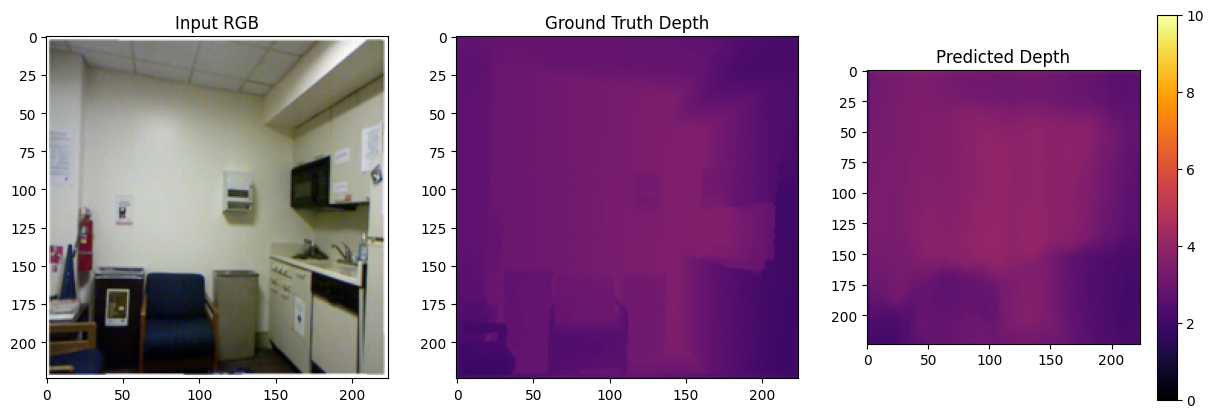

In [14]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch
import os
from tqdm.notebook import tqdm

def train_and_evaluate(model_name, model, train_loader, val_loader, save_dir, epochs=3):
    device = CONFIG['device']
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=0.1)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    criterion = SILogLoss()

    # Initialize loss and metric trackers
    train_losses_history = []
    val_losses_history = []

    scaler = torch.amp.GradScaler('cuda')

    save_path = os.path.join(save_dir, f"{model_name}_best.pth")
    best_a1 = 0.0

    print(f"\n {model_name} AMP + Cosine Annealing ...")

    for epoch in range(epochs):
        model.train()

        for param in model.parameters():
            if not param.requires_grad:
                param.requires_grad = True

        train_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, gts in pbar:
            imgs, gts = imgs.to(device), gts.to(device)
            mask = (gts > 0.1) & (gts < CONFIG['max_depth'])

            optimizer.zero_grad()

            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                preds = model(imgs)
                preds = torch.clamp(preds, min=1e-3, max=CONFIG['max_depth'])
                loss = criterion(preds, gts, mask)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        # Calculate and record average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)
        train_losses_history.append(avg_train_loss)

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        val_metrics = validate_model(model, val_loader, device)
        current_rmse = val_metrics['rmse']
        current_a1 = val_metrics['a1']
        val_losses_history.append(current_rmse)

        print(f"Epoch {epoch+1} (LR={current_lr:.2e}): "
              f"Loss={train_loss/len(train_loader):.3f} | "
              f"AbsRel={val_metrics['abs_rel']:.3f} | "
              f"RMSE={val_metrics['rmse']:.3f} | "
              f"δ1={val_metrics['a1']:.3f}")

        if current_a1 > best_a1:
            best_a1 = current_a1

            print(f"Higher acc (δ1: {best_a1:.3f})! Saving...")

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_a1': best_a1,
                'config': CONFIG
            }, save_path)

            print(f"Model has been saved: {save_path}")

    return val_metrics, train_losses_history, val_losses_history
if __name__ == "__main__":

    swin_results, swin_train_loss, swin_val_loss = train_and_evaluate(
        "Swin-Tiny", swin_model, train_loader, val_loader, save_dir, epochs=CONFIG['epochs']
    )

    resnet_results, resnet_train_loss, resnet_val_loss = train_and_evaluate(
        "ResNet-34", resnet_model, train_loader, val_loader, save_dir, epochs=CONFIG['epochs']
    )

    print("\n" + "="*50)
    print(f"{'Metric':<10} | {'Swin-Tiny (Ours)':<18} | {'ResNet-34 (Base)':<18}")
    print("-" * 50)
    print(f"{'AbsRel':<10} | {swin_results['abs_rel']:<18.4f} | {resnet_results['abs_rel']:<18.4f}")
    print(f"{'RMSE':<10} | {swin_results['rmse']:<18.4f} | {resnet_results['rmse']:<18.4f}")
    print(f"{'δ1 (Acc)':<10} | {swin_results['a1']:<18.4f} | {resnet_results['a1']:<18.4f}")
    print(f"{'δ2 ':<10} | {swin_results['a2']:<18.4f} | {resnet_results['a2']:<18.4f}")
    print("="*50)

    print("Visualize Swin-Tiny:")
    visualize_batch(swin_model, val_loader, CONFIG['device'])


Visualizing Loss Curves:


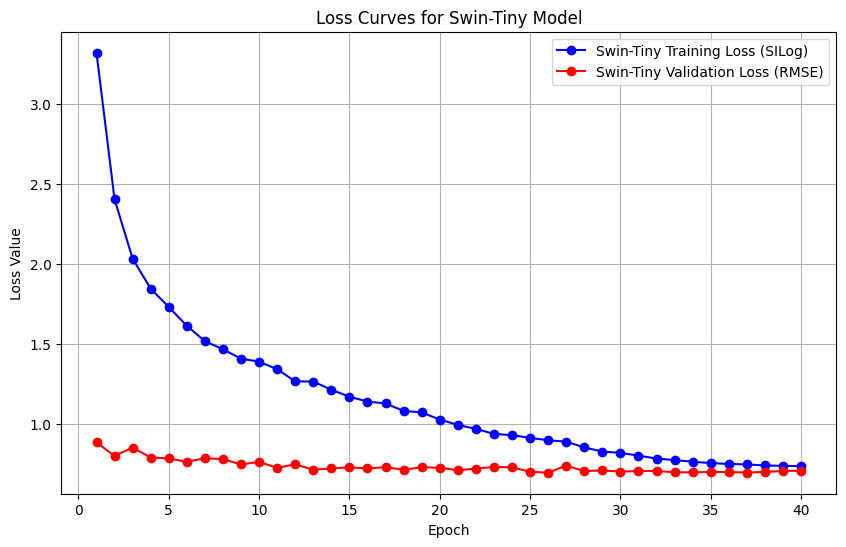

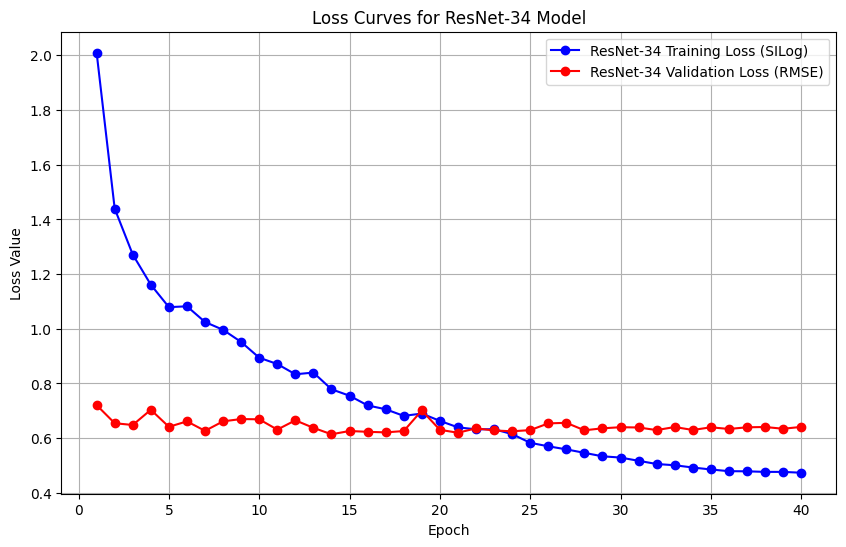

In [15]:
# --- Plot Loss Curves ---
print("\nVisualizing Loss Curves:")
plot_loss_curves("Swin-Tiny", swin_train_loss, swin_val_loss)
plot_loss_curves("ResNet-34", resnet_train_loss, resnet_val_loss)

In [16]:
print("\n" + "="*65)
print(f"{'Metric':<12} | {'Swin-Tiny (Ours)':<20} | {'ResNet-34 (Base)':<20}")
print("="*65)

# Error
print(f"{'AbsRel (↓)':<12} | {swin_results['abs_rel']:<20.4f} | {resnet_results['abs_rel']:<20.4f}")
print(f"{'RMSE   (↓)':<12} | {swin_results['rmse']:<20.4f} | {resnet_results['rmse']:<20.4f}")


print("-" * 65)

# ACC
print(f"{'δ1     (↑)':<12} | {swin_results['a1']:<20.4f} | {resnet_results['a1']:<20.4f}")
print(f"{'δ2     (↑)':<12} | {swin_results['a2']:<20.4f} | {resnet_results['a2']:<20.4f}")
print(f"{'δ3     (↑)':<12} | {swin_results['a3']:<20.4f} | {resnet_results['a3']:<20.4f}")

print("="*65)


Metric       | Swin-Tiny (Ours)     | ResNet-34 (Base)    
AbsRel (↓)   | 0.1695               | 0.1502              
RMSE   (↓)   | 0.7081               | 0.6412              
-----------------------------------------------------------------
δ1     (↑)   | 0.7433               | 0.7927              
δ2     (↑)   | 0.9336               | 0.9518              
δ3     (↑)   | 0.9821               | 0.9879              


Finetune

In [18]:


Standard_Full = load_dataset("0jl/NYUv2", split="train", trust_remote_code=True)
# 795 Training Set
Standard_Train = Standard_Full.select(range(795))
# 654 Testing Set
Standard_Test = Standard_Full.select(range(795, 1449))

ft_train_dataset = HF_NYUDepthDataset(Standard_Train, is_train=True)
ft_val_dataset = HF_NYUDepthDataset(Standard_Test, is_train=False)

ft_train_loader = DataLoader(ft_train_dataset, batch_size=16, shuffle=True, num_workers=0,pin_memory=True)
ft_val_loader = DataLoader(ft_val_dataset, batch_size=16, shuffle=False, num_workers=0,pin_memory=True)


In [19]:

print("Fine-tuning Swin-Tiny...")

from google.colab import drive
drive.mount('/content/drive')

load_path = '/content/drive/MyDrive/DepthProject/Swin-Tiny_best.pth'

if os.path.exists(load_path):
    checkpoint = torch.load(load_path)
    swin_ft_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"δ1: {checkpoint['best_a1']:.3f}")
else:
    print("File doesn't exist")

# Hyperparameter
CONFIG['lr'] = 1e-5

print("Start Fine-tuning on 795 images")
ft_swin_results, ft_swin_loss, ft_swin_val_loss = train_and_evaluate("Swin-Tiny-FT", swin_ft_model, ft_train_loader, ft_val_loader, save_dir,epochs=10)


Fine-tuning Swin-Tiny...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
δ1: 0.747
Start Fine-tuning on 795 images

 Swin-Tiny-FT AMP + Cosine Annealing ...


Epoch 1/10:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()


Epoch 1 (LR=9.78e-06): Loss=2.358 | AbsRel=0.147 | RMSE=0.587 | δ1=0.815
Higher acc (δ1: 0.815)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny-FT_best.pth


Epoch 2/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 (LR=9.14e-06): Loss=2.263 | AbsRel=0.161 | RMSE=0.609 | δ1=0.798


Epoch 3/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 (LR=8.15e-06): Loss=2.191 | AbsRel=0.157 | RMSE=0.586 | δ1=0.805


Epoch 4/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 (LR=6.89e-06): Loss=2.133 | AbsRel=0.174 | RMSE=0.626 | δ1=0.780


Epoch 5/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 (LR=5.50e-06): Loss=2.078 | AbsRel=0.149 | RMSE=0.587 | δ1=0.815
Higher acc (δ1: 0.815)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny-FT_best.pth


Epoch 6/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6 (LR=4.11e-06): Loss=2.083 | AbsRel=0.154 | RMSE=0.601 | δ1=0.809


Epoch 7/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 (LR=2.85e-06): Loss=2.028 | AbsRel=0.137 | RMSE=0.562 | δ1=0.828
Higher acc (δ1: 0.828)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/Swin-Tiny-FT_best.pth


Epoch 8/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8 (LR=1.86e-06): Loss=2.020 | AbsRel=0.151 | RMSE=0.582 | δ1=0.814


Epoch 9/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9 (LR=1.22e-06): Loss=2.032 | AbsRel=0.156 | RMSE=0.600 | δ1=0.807


Epoch 10/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10 (LR=1.00e-06): Loss=2.025 | AbsRel=0.152 | RMSE=0.588 | δ1=0.812


In [20]:

print("\n" + "="*65)
print(f"{'Metric':<12} | {'Swin-Tiny':<20}")
print("="*65)

print(f"{'AbsRel (↓)':<12} | {ft_swin_results['abs_rel']:<20.4f}")
print(f"{'RMSE   (↓)':<12} | {ft_swin_results['rmse']:<20.4f}")

print("-" * 65)

print(f"{'δ1     (↑)':<12} | {ft_swin_results['a1']:<20.4f}")
print(f"{'δ2     (↑)':<12} | {ft_swin_results['a2']:<20.4f}")
print(f"{'δ3     (↑)':<12} | {ft_swin_results['a3']:<20.4f}")


Metric       | Swin-Tiny           
AbsRel (↓)   | 0.1523              
RMSE   (↓)   | 0.5876              
-----------------------------------------------------------------
δ1     (↑)   | 0.8122              
δ2     (↑)   | 0.9616              
δ3     (↑)   | 0.9903              


In [21]:
print("Fine-tuning Resnet...")

from google.colab import drive
drive.mount('/content/drive')

load_path = '/content/drive/MyDrive/DepthProject/ResNet-34_best.pth'

if os.path.exists(load_path):
    checkpoint = torch.load(load_path)
    resnet_ft_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"δ1: {checkpoint['best_a1']:.3f}")
else:
    print("File doesn't exist")

CONFIG['lr'] = 1e-5

print("Start Fine-tuning on 795 images")
ft_res_results, ft_res_loss, ft_res_val_loss = train_and_evaluate("ResNet-34-FT", resnet_ft_model, ft_train_loader, ft_val_loader, save_dir,epochs=10)

Fine-tuning Resnet...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
δ1: 0.797
Start Fine-tuning on 795 images

 ResNet-34-FT AMP + Cosine Annealing ...


Epoch 1/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 (LR=9.78e-06): Loss=2.193 | AbsRel=0.130 | RMSE=0.544 | δ1=0.853
Higher acc (δ1: 0.853)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34-FT_best.pth


Epoch 2/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 (LR=9.14e-06): Loss=2.122 | AbsRel=0.135 | RMSE=0.530 | δ1=0.852


Epoch 3/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 (LR=8.15e-06): Loss=2.056 | AbsRel=0.130 | RMSE=0.530 | δ1=0.858
Higher acc (δ1: 0.858)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34-FT_best.pth


Epoch 4/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 (LR=6.89e-06): Loss=2.021 | AbsRel=0.139 | RMSE=0.554 | δ1=0.845


Epoch 5/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 (LR=5.50e-06): Loss=1.990 | AbsRel=0.127 | RMSE=0.514 | δ1=0.862
Higher acc (δ1: 0.862)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34-FT_best.pth


Epoch 6/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6 (LR=4.11e-06): Loss=1.950 | AbsRel=0.121 | RMSE=0.504 | δ1=0.869
Higher acc (δ1: 0.869)! Saving...
Model has been saved: /content/drive/MyDrive/DepthProject/ResNet-34-FT_best.pth


Epoch 7/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 (LR=2.85e-06): Loss=1.986 | AbsRel=0.124 | RMSE=0.515 | δ1=0.866


Epoch 8/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8 (LR=1.86e-06): Loss=1.930 | AbsRel=0.126 | RMSE=0.507 | δ1=0.865


Epoch 9/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9 (LR=1.22e-06): Loss=1.920 | AbsRel=0.126 | RMSE=0.519 | δ1=0.864


Epoch 10/10:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10 (LR=1.00e-06): Loss=1.928 | AbsRel=0.126 | RMSE=0.515 | δ1=0.864


In [22]:
print("\n" + "="*65)
print(f"{'Metric':<12} | {'ResNet-34 (Base)':<20}")
print("="*65)

print(f"{'AbsRel (↓)':<12} | {ft_res_results['abs_rel']:<20.4f}")
print(f"{'RMSE   (↓)':<12} | {ft_res_results['rmse']:<20.4f}")

print("-" * 65)

print(f"{'δ1     (↑)':<12} | {ft_res_results['a1']:<20.4f}")
print(f"{'δ2     (↑)':<12} | {ft_res_results['a2']:<20.4f}")
print(f"{'δ3     (↑)':<12} | {ft_res_results['a3']:<20.4f}")


Metric       | ResNet-34 (Base)    
AbsRel (↓)   | 0.1259              
RMSE   (↓)   | 0.5146              
-----------------------------------------------------------------
δ1     (↑)   | 0.8642              
δ2     (↑)   | 0.9745              
δ3     (↑)   | 0.9936              



Visualizing Loss Curves:


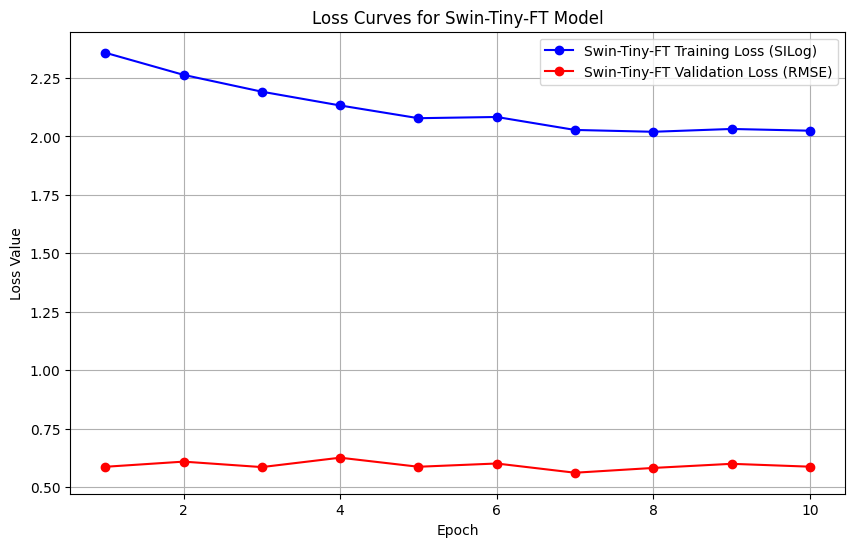

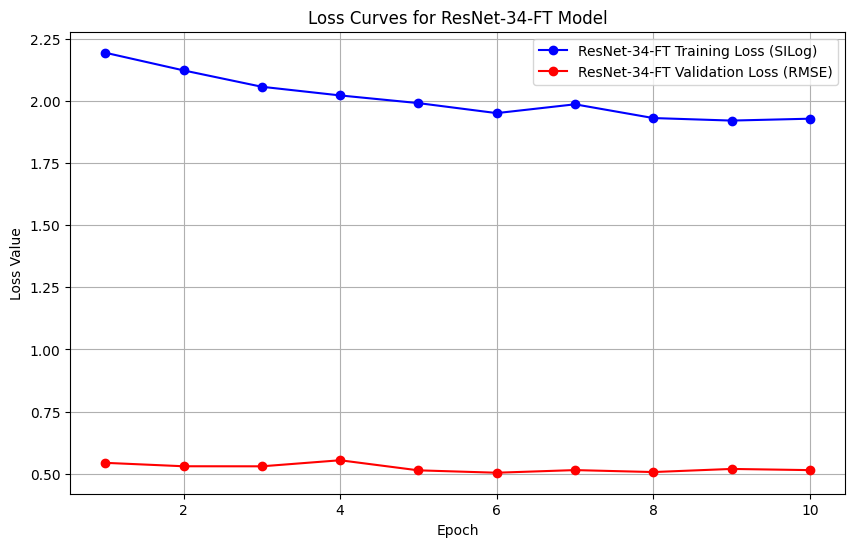

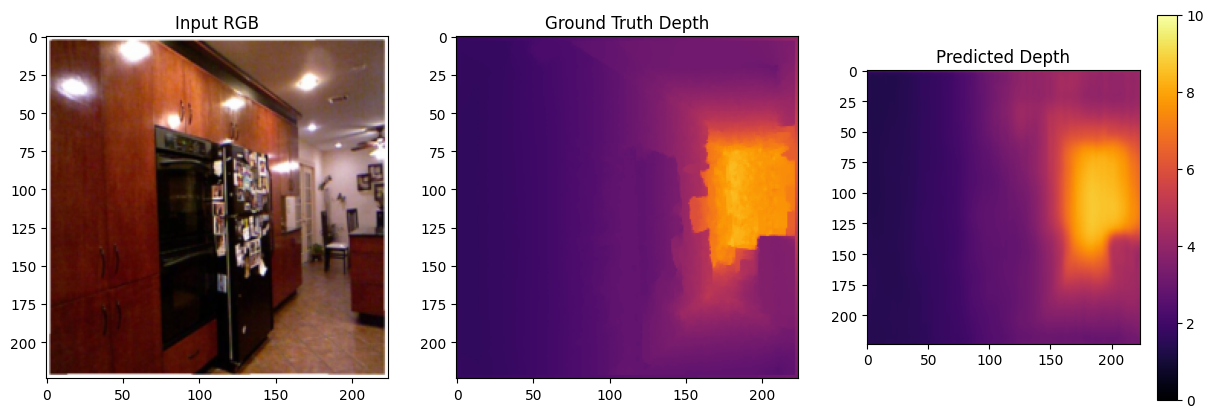

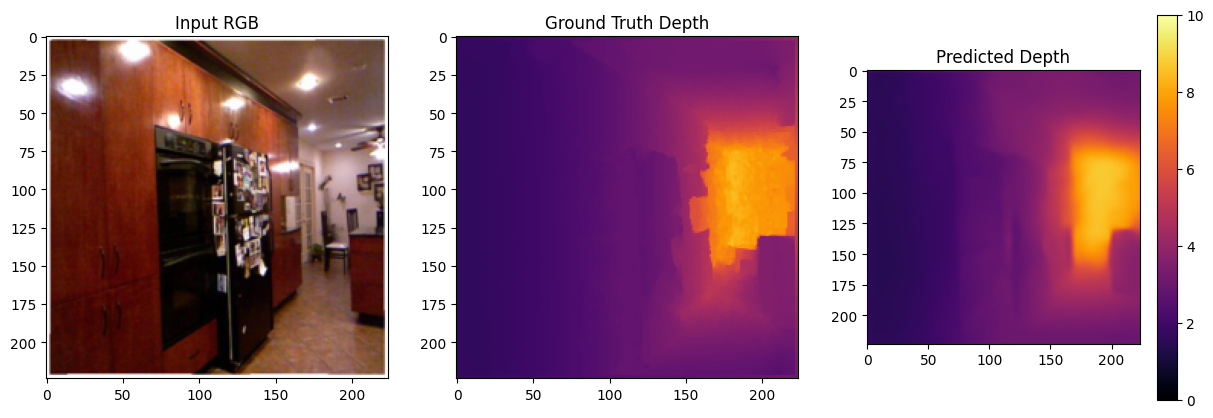

In [31]:
# --- Plot Loss Curves ---
print("\nVisualizing Loss Curves:")
plot_loss_curves("Swin-Tiny-FT", ft_swin_loss, ft_swin_val_loss)
plot_loss_curves("ResNet-34-FT", ft_res_loss, ft_res_val_loss)
visualize_batch(swin_ft_model, ft_val_loader, CONFIG['device'])
visualize_batch(resnet_ft_model, ft_val_loader, CONFIG['device'])
